# BDL01 Semesterproject
## Analysis On Police-registered traffic accidents in the canton of Zurich

The traffic accident statistics of the Canton of Zurich (VUSTA) contains the road traffic accidents with personal injury and property damage registered by the Cantonal Police of Zurich, the Traffic Department of the City of Zurich and the Winterthur City Police. It is updated once a year, towards the end of the first quarter of the following year. The dataset covers the time from January 1, 2011 - December 31, 2020

![AccidentDatamodell](Images/AccidentsDatamodell.png)


![Dataflow](Images/Dataflow.png)

# Installation, Requirements

In [1]:
#! pip3 list | grep -E 'pymongo|json|pandas|requests|matplotlib|numpy|pprint'

In [2]:
import pandas as pd
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import requests
from datetime import datetime
from datetime import timedelta
import time
import json
import bigjson
import numpy as np
from pymongo.errors import DuplicateKeyError
from pymongo.errors import OperationFailure, DuplicateKeyError
import matplotlib.pyplot as plt

pd.set_option('precision', 2)
pd.set_option('max_rows', 20)
pd.set_option('max_colwidth', 30)
# pd.describe_option('max_rows')
# pd.describe_option('precision')
# pd.describe_option('max_colwidth')
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (20,10)
#Reset do default figsize
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### Connect, dbs

In [3]:
client = MongoClient(host="localhost",port=27017)
database = client["bdl03"]

# ETL/ ELT 
    

## Import Files

The accident data can be retrieved from https://opendata.swiss/en/dataset/polizeilich-registrierte-verkehrsunfalle-im-kanton-zurich/resource/e0758b22-1e77-4d96-aacd-18ced0ba3781 or directly be read from https://www.web.statistik.zh.ch/ogd/data/kapo/RoadTrafficAccidentLocations.json

In [4]:
request = requests.get("https://www.web.statistik.zh.ch/ogd/data/kapo/RoadTrafficAccidentLocations.json")
if request.status_code == 200:
        data = request.json()

In [5]:
#data

In [6]:
    #try:
        #database.Accidents.insert_one(data)

    

In [7]:
c = database.Accidents.aggregate([
      {"$limit": 1},
])

for doc in c:
     pprint(f"{doc}"[:5000])

("{'_id': ObjectId('60afc7769ddbd12dc82a1da1'), 'AccidentUID': "
 "'A70191D0D45E00B0E0430A83942700B0', 'AccidentType': 'at0', "
 "'AccidentType_de': 'Schleuder- oder Selbstunfall', 'AccidentType_fr': "
 "'dérapage ou perte de maîtrise', 'AccidentType_it': 'Incidente di "
 "sbandamento o per colpa propria', 'AccidentType_en': 'Accident with skidding "
 "or self-accident', 'AccidentSeverityCategory': 'as4', "
 "'AccidentSeverityCategory_de': 'Unfall mit Sachschaden', "
 "'AccidentSeverityCategory_fr': 'accident avec dommages matériels', "
 "'AccidentSeverityCategory_it': 'Incidente con danni materiali', "
 "'AccidentSeverityCategory_en': 'Accident with property damage', "
 "'AccidentInvolvingPedestrian': 'false', 'AccidentInvolvingBicycle': 'false', "
 "'AccidentInvolvingMotorcycle': 'false', 'RoadType': 'rt432', 'RoadType_de': "
 "'Hauptstrasse', 'RoadType_fr': 'route principale', 'RoadType_it': 'Strada "
 "principale', 'RoadType_en': 'Principal road', 'AccidentLocation_CHLV95_E': "
 "'

In [8]:
c = database.Accidents.aggregate([
      {"$limit": 1},
])

pd.DataFrame(c)

,_id,AccidentUID,AccidentType,AccidentType_de,AccidentType_fr,AccidentType_it,AccidentType_en,AccidentSeverityCategory,AccidentSeverityCategory_de,AccidentSeverityCategory_fr,AccidentSeverityCategory_it,AccidentSeverityCategory_en,AccidentInvolvingPedestrian,AccidentInvolvingBicycle,AccidentInvolvingMotorcycle,RoadType,RoadType_de,RoadType_fr,RoadType_it,RoadType_en,AccidentLocation_CHLV95_E,AccidentLocation_CHLV95_N,CantonCode,MunicipalityCode,AccidentYear,AccidentMonth,AccidentMonth_de,AccidentMonth_fr,AccidentMonth_it,AccidentMonth_en,AccidentWeekDay,AccidentWeekDay_de,AccidentWeekDay_fr,AccidentWeekDay_it,AccidentWeekDay_en,AccidentHour,AccidentHour_text
0,60afc7769ddbd12dc82a1da1,A70191D0D45E00B0E0430A8394...,at0,Schleuder- oder Selbstunfall,dérapage ou perte de maîtrise,Incidente di sbandamento o...,Accident with skidding or ...,as4,Unfall mit Sachschaden,accident avec dommages mat...,Incidente con danni materiali,Accident with property damage,false,false,false,rt432,Hauptstrasse,route principale,Strada principale,Principal road,2676380,1250175,ZH,0247,2011,1,Januar,janvier,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,00,00h-01h


## Validate Fields

In [9]:
c = database.Accidents.aggregate([
    {"$match": {"AccidentType_en": {"$exists" : False}}},
])

pd.DataFrame(c)

""


In [10]:
c = database.Accidents.aggregate([
    {"$match": {'AccidentSeverityCategory_de': {"$in" : ['Unfall mit Sachschaden']}}},
])


df = pd.DataFrame(c)

### (Re)Create Accidents collection

In [11]:
c = database.Accidents.aggregate([
    {"$project": {"_id": "$AccidentUID", 'AccidentType':1, 'AccidentType_en':1,
       'AccidentSeverityCategory':1, 
       'AccidentSeverityCategory_en':1, 'AccidentInvolvingPedestrian':1,
       'AccidentInvolvingBicycle':1, 'AccidentInvolvingMotorcycle':1, 'RoadType':1, 'RoadType_en':1,'CantonCode':1,
       'MunicipalityCode':1, 'AccidentYear':1, 'AccidentMonth':1,'AccidentMonth_en':1,
       'AccidentWeekDay':1, 'AccidentWeekDay_en':1, 'AccidentHour':1,
       'AccidentHour_text':1}},
])
df = pd.DataFrame(c)

In [12]:
df.head()

,AccidentType,AccidentType_en,AccidentSeverityCategory,AccidentSeverityCategory_en,AccidentInvolvingPedestrian,AccidentInvolvingBicycle,AccidentInvolvingMotorcycle,RoadType,RoadType_en,CantonCode,MunicipalityCode,AccidentYear,AccidentMonth,AccidentMonth_en,AccidentWeekDay,AccidentWeekDay_en,AccidentHour,AccidentHour_text,_id
0,at0,Accident with skidding or ...,as4,Accident with property damage,false,false,false,rt432,Principal road,ZH,0247,2011,1,January,aw406,Saturday,00,00h-01h,A70191D0D45E00B0E0430A8394...
1,at0,Accident with skidding or ...,as4,Accident with property damage,false,false,false,rt433,Minor road,ZH,0261,2011,1,January,aw406,Saturday,00,00h-01h,A2D2677533867004E0430A865E...
2,at0,Accident with skidding or ...,as3,Accident with light injuries,false,true,false,rt433,Minor road,ZH,0261,2011,1,January,aw406,Saturday,01,01h-02h,9FD6441F802C20A6E0430A865E...
3,at0,Accident with skidding or ...,as4,Accident with property damage,false,false,false,rt430,Motorway,ZH,0251,2011,1,January,aw406,Saturday,01,01h-02h,A7016B9BBC3301A8E0430A8394...
4,at0,Accident with skidding or ...,as4,Accident with property damage,false,false,false,rt439,Other,ZH,0261,2011,1,January,aw406,Saturday,02,02h-03h,9FDA0DC4856A6094E0430A865E...


In [13]:
df.columns

Index(['AccidentType', 'AccidentType_en', 'AccidentSeverityCategory',
       'AccidentSeverityCategory_en', 'AccidentInvolvingPedestrian',
       'AccidentInvolvingBicycle', 'AccidentInvolvingMotorcycle', 'RoadType',
       'RoadType_en', 'CantonCode', 'MunicipalityCode', 'AccidentYear',
       'AccidentMonth', 'AccidentMonth_en', 'AccidentWeekDay',
       'AccidentWeekDay_en', 'AccidentHour', 'AccidentHour_text', '_id'],
      dtype='object')

## Municipality Information
To get a Municipality Name to the Municipality code an .xls file has been downloaded from https://www.bfs.admin.ch/bfs/de/home/grundlagen/agvch.assetdetail.16924990.html. I then created a .csv where only the municipalities from Zurich are listed. (bfs_municipality.csv can be found in the zip)

![GemeindenData](Images/GemeindeDatamodell.png)

### Drop the Gemeinden Collection

In [14]:
database.gemeinden.drop()
c = database.list_collections()
pd.DataFrame(c)

,name,type,options,info,idIndex
0,Accidents,collection,{},"{'readOnly': False, 'uuid'...","{'v': 2, 'key': {'_id': 1}..."


In [15]:
gemeinden_df = pd.read_csv('bfs_municipality.csv',sep=";")   # loading csv file

row_dict={}
for column in gemeinden_df:
    row_dict[column]= []

for index, row in gemeinden_df.iterrows():
    json_row =row.to_dict()
    #print(json_row)
    database.gemeinden.insert_one(json_row)
    
    

In [16]:
gemeinden_df.columns

Index(['GDEKT', 'GDEBZNR', 'GDENR', 'GDENAME', 'GDENAMK', 'GDEBZNA', 'GDEKTNA',
       'GDEMUTDAT'],
      dtype='object')

In [17]:
c=database.gemeinden.aggregate([
      {"$limit": 1},
])

pd.DataFrame(c)

,_id,GDEKT,GDEBZNR,GDENR,GDENAME,GDENAMK,GDEBZNA,GDEKTNA,GDEMUTDAT
0,60b00be931332501ad713488,ZH,101.0,1.0,Aeugst am Albis,Aeugst am Albis,Bezirk Affoltern,Zürich,1976-11-15


## Convert Municipality Code to Int

In [18]:
priceQtyConversionStage = {
   '$addFields': {
      'IntMunicipalityCode': { "$toInt": "$MunicipalityCode" },
   }
}

c=database.Accidents.aggregate( [
   priceQtyConversionStage,
])
e=pd.DataFrame(c)


In [19]:
e.head()

,_id,AccidentUID,AccidentType,AccidentType_de,AccidentType_fr,AccidentType_it,AccidentType_en,AccidentSeverityCategory,AccidentSeverityCategory_de,AccidentSeverityCategory_fr,AccidentSeverityCategory_it,AccidentSeverityCategory_en,AccidentInvolvingPedestrian,AccidentInvolvingBicycle,AccidentInvolvingMotorcycle,RoadType,RoadType_de,RoadType_fr,RoadType_it,RoadType_en,AccidentLocation_CHLV95_E,AccidentLocation_CHLV95_N,CantonCode,MunicipalityCode,AccidentYear,AccidentMonth,AccidentMonth_de,AccidentMonth_fr,AccidentMonth_it,AccidentMonth_en,AccidentWeekDay,AccidentWeekDay_de,AccidentWeekDay_fr,AccidentWeekDay_it,AccidentWeekDay_en,AccidentHour,AccidentHour_text,IntMunicipalityCode
0,60afc7769ddbd12dc82a1da1,A70191D0D45E00B0E0430A8394...,at0,Schleuder- oder Selbstunfall,dérapage ou perte de maîtrise,Incidente di sbandamento o...,Accident with skidding or ...,as4,Unfall mit Sachschaden,accident avec dommages mat...,Incidente con danni materiali,Accident with property damage,false,false,false,rt432,Hauptstrasse,route principale,Strada principale,Principal road,2676380,1250175,ZH,0247,2011,1,Januar,janvier,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,00,00h-01h,247
1,60afc7769ddbd12dc82a1da2,A2D2677533867004E0430A865E...,at0,Schleuder- oder Selbstunfall,dérapage ou perte de maîtrise,Incidente di sbandamento o...,Accident with skidding or ...,as4,Unfall mit Sachschaden,accident avec dommages mat...,Incidente con danni materiali,Accident with property damage,false,false,false,rt433,Nebenstrasse,route secondaire,Strada secondaria,Minor road,2684605,1245194,ZH,0261,2011,1,Januar,janvier,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,00,00h-01h,261
2,60afc7769ddbd12dc82a1da3,9FD6441F802C20A6E0430A865E...,at0,Schleuder- oder Selbstunfall,dérapage ou perte de maîtrise,Incidente di sbandamento o...,Accident with skidding or ...,as3,Unfall mit Leichtverletzten,accident avec blessés légers,Incidente con feriti leggeri,Accident with light injuries,false,true,false,rt433,Nebenstrasse,route secondaire,Strada secondaria,Minor road,2682382,1246980,ZH,0261,2011,1,Januar,janvier,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,01,01h-02h,261
3,60afc7769ddbd12dc82a1da4,A7016B9BBC3301A8E0430A8394...,at0,Schleuder- oder Selbstunfall,dérapage ou perte de maîtrise,Incidente di sbandamento o...,Accident with skidding or ...,as4,Unfall mit Sachschaden,accident avec dommages mat...,Incidente con danni materiali,Accident with property damage,false,false,false,rt430,Autobahn,autoroute,Autostrada,Motorway,2674666,1251733,ZH,0251,2011,1,Januar,janvier,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,01,01h-02h,251
4,60afc7769ddbd12dc82a1da5,9FDA0DC4856A6094E0430A865E...,at0,Schleuder- oder Selbstunfall,dérapage ou perte de maîtrise,Incidente di sbandamento o...,Accident with skidding or ...,as4,Unfall mit Sachschaden,accident avec dommages mat...,Incidente con danni materiali,Accident with property damage,false,false,false,rt439,andere,autre,Altro,Other,2682791,1247749,ZH,0261,2011,1,Januar,janvier,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,02,02h-03h,261


# Data Analysis

## Categories

In [20]:
c = database.Accidents.aggregate([
    {"$project": {'AccidentType':0,  'AccidentSeverityCategory':0, 'AccidentInvolvingPedestrian':0,
       'AccidentInvolvingBicycle':0, 'AccidentInvolvingMotorcycle':0, 'RoadType':0,
       'RoadType_en':0, 'CantonCode':0, 'MunicipalityCode':0, 'AccidentYear':0,
       'AccidentMonth':0, 'AccidentMonth_en':0, 'AccidentWeekDay':0,
       'AccidentWeekDay_en':0, 'AccidentHour':0, 'AccidentHour_text':0}},
    {"$unwind": "$AccidentSeverityCategory_en"},
    {"$group": {"_id": "$AccidentSeverityCategory_en", "count": {"$sum": 1}}},
 ])

df = pd.DataFrame(c)
print(df)

                             _id   count
0   Accident with light injuries   26208
1  Accident with property damage  115793
2       Accident with fatalities     286
3  Accident with severe injuries    5684


Eventhoug there are alot of accidents in the canton of Zürich, there are gladly almost no accidents with fatalities.  

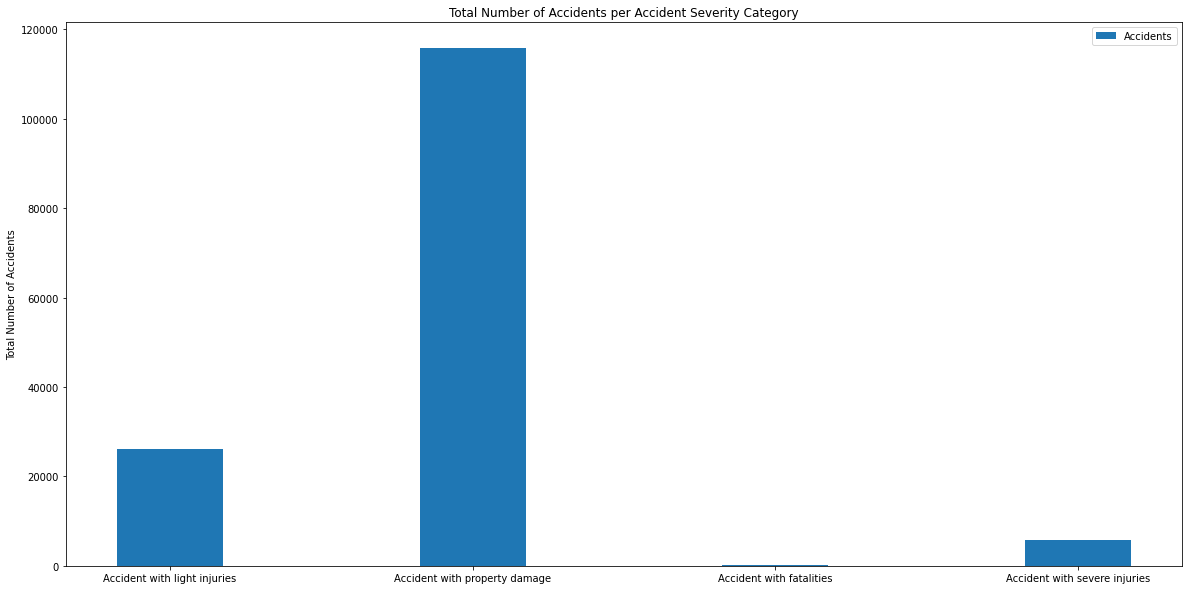

In [21]:
labels = df["_id"]

width = 0.35       # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()

ax.bar(labels, df["count"], width, label='Accidents')

ax.set_ylabel('Total Number of Accidents')
ax.set_title('Total Number of Accidents per Accident Severity Category')
ax.legend()

plt.show()

In [22]:
c = database.Accidents.aggregate([
    {"$project": {'AccidentType':0,  'AccidentSeverityCategory':0, 'AccidentInvolvingPedestrian':0,
       'AccidentInvolvingBicycle':0, 'AccidentInvolvingMotorcycle':0, 'RoadType':0,
       'RoadType_en':0, 'CantonCode':0, 'MunicipalityCode':0, 'AccidentYear':0,
       'AccidentMonth':0, 'AccidentMonth_en':0, 'AccidentWeekDay':0,
       'AccidentWeekDay_en':0, 'AccidentHour':0, 'AccidentHour_text':0}},
    {"$unwind": "$AccidentType_en"},
    {"$group": {"_id": "$AccidentType_en", "count": {"$sum": 1}}},
 ])

df = pd.DataFrame(c)
print(df)

                              _id  count
0                           Other   1755
1   Accident involving pedestr...   4849
2   Accident when turning-into...  10486
3   Accident when turning left...   6295
4   Accident with skidding or ...  49019
5           Accident when parking  25583
6   Accident with rear-end col...  29513
7    Accident involving animal(s)   2642
8   Accident when overtaking o...  11830
9   Accident when crossing the...   4159
10  Accident with head-on coll...   1840


<ipython-input-23-25c4e054aff2>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation = 90)


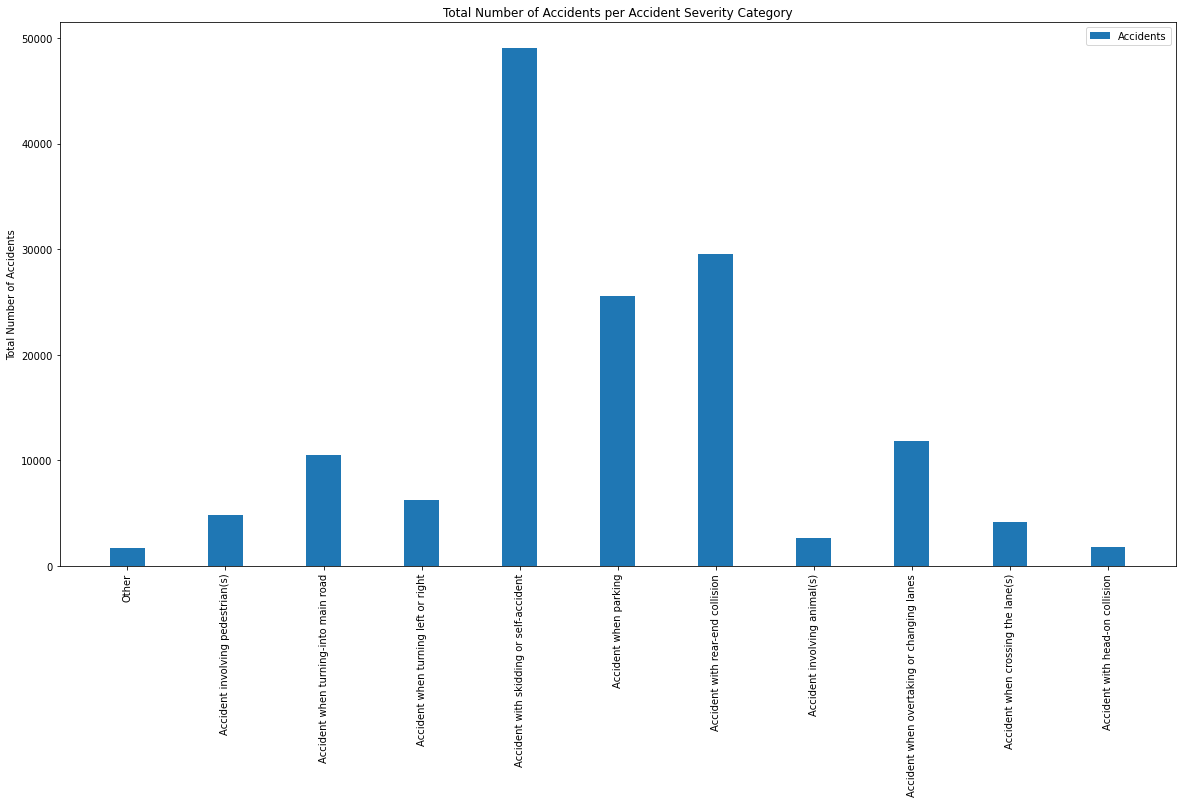

In [23]:
labels = df["_id"]

width = 0.35       # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()

ax.bar(labels, df["count"], width, label='Accidents')
#plt.xticks(rotation = 45) 
ax.set_xticklabels(labels, rotation = 90)
ax.set_ylabel('Total Number of Accidents')
ax.set_title('Total Number of Accidents per Accident Severity Category')
ax.legend()

plt.show()

It is interesting to see, that most accidents are skiddin or self accidents. The next biggest accident type is accidents with rear-end collisions.  We can see, that a lot of accidents could be prevented if drivers would be more attentive.

In [24]:
c = database.Accidents.aggregate([
    {"$project": {'AccidentType':0,  'AccidentSeverityCategory':0, 'AccidentInvolvingPedestrian':0,
       'AccidentInvolvingBicycle':0, 'AccidentInvolvingMotorcycle':0, 'RoadType':0,
       'RoadType_en':0, 'AccidentYear':0,
       'AccidentMonth':0, 'AccidentMonth_en':0, 'AccidentWeekDay':0,
       'AccidentWeekDay_en':0, 'AccidentHour':0, 'AccidentHour_text':0}},
    {"$unwind": "$MunicipalityCode"},
    {"$group": {"_id": "$MunicipalityCode", "count": {"$sum": 1}}},
 ])

df = pd.DataFrame(c)


In [25]:
df.head()

,_id,count
0,0112,445
1,0031,213
2,0072,315
3,0037,98
4,0248,187


Unfortunately I was not able to merge the two collections on the MunicipalyCode. In a future project it would be very interesting to analyse in more detail, in which municipalities the most accidents happen.

The figure below shows one municipality standing out. I believe that this is the city of Zürich.

<ipython-input-26-d09722fe2115>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation = 90)


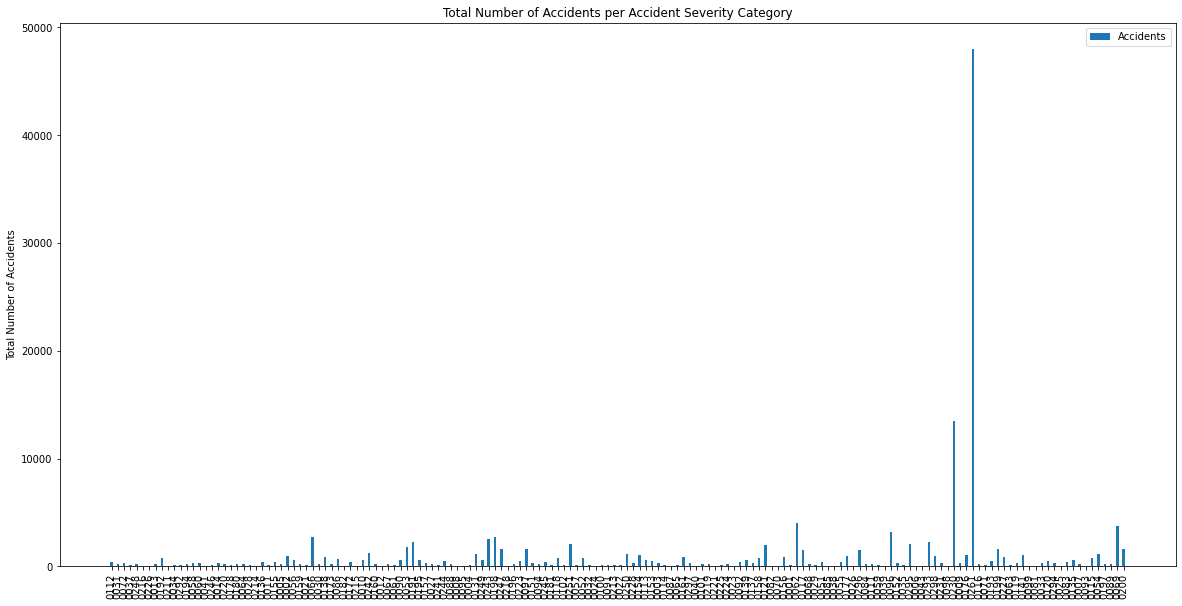

In [26]:
labels = df["_id"]

width = 0.39       # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()

ax.bar(labels, df["count"], width, label='Accidents')
#plt.xticks(rotation = 45) 
ax.set_xticklabels(labels, rotation = 90)
ax.set_ylabel('Total Number of Accidents')
ax.set_title('Total Number of Accidents per Accident Severity Category')
ax.legend()

plt.show()

# Conclusion

MongoDB, the most popular NoSQL database, is a relative newcomer in the database industry. It's an excellent tool for creating data warehouses, because because of its ability to fully exploit so-called "shared-nothing cluster architecture." Because it is an open-source database, it is perfect for creating high-performance data warehouses.

This semester project served as an excellent introduction to MongoDB. It needs some time to get used to the syntax. However, one rapidly grows used to it.

